<a href="https://colab.research.google.com/github/jagatabhay/TSAI/blob/master/S6/S6_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from itertools import chain
from inspect import signature
from functools import lru_cache as cache
from collections import defaultdict, namedtuple
#from torch.utils import 

**Target**: create an architecture with less than 10k parameters so accordingly chooses the imput and output channels.Here I have choosen the channels between 10 and 20.

**Analysis**: Adding dropout after max pooling has yielded better results in terms
of Accuracy rather than after each layer

In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias
        
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        #self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        #self.pool1 = nn.MaxPool2d(2, 2)
        #self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        #self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        #self.pool2 = nn.MaxPool2d(2, 2)
        #self.conv5 = nn.Conv2d(256, 512, 3)
        #self.conv6 = nn.Conv2d(512, 1024, 3)
        #self.conv7 = nn.Conv2d(1024, 10, 3)
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   #nn.BatchNorm2d(num_features=10),
                                   GhostBatchNorm(10,2)
                                   #nn.Dropout(0.1)
                                   )

        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=10,out_channels=16,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   #nn.BatchNorm2d(num_features=16),
                                   GhostBatchNorm(16,2)
                                   #nn.Dropout(0.1)
        )
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=16,out_channels=20,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   #nn.BatchNorm2d(num_features=20),
                                   GhostBatchNorm(20,2)
                                   #nn.Dropout(0.1)
                                   )                          
        
        self.pool1 =  nn.MaxPool2d(2,2)
         
        
        
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=20,out_channels=10,kernel_size=(1,1),padding=0),
                                   nn.ReLU(),
                                   #nn.BatchNorm2d(num_features=10),
                                   GhostBatchNorm(10,2),
                                   nn.Dropout(0.1)
                                   ) 
        
        #self.pool2 =  nn.MaxPool2d(2,2)

        self.conv5 = nn.Sequential(nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=20),
                                   GhostBatchNorm(20,2)
                                   #nn.Dropout(0.1)
                                   ) 
        
        self.conv6 = nn.Sequential(nn.Conv2d(in_channels=20,out_channels=16,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   #nn.BatchNorm2d(num_features=16),
                                   GhostBatchNorm(16,2)
                                   #nn.Dropout(0.1)
                                   ) 
        self.conv7 = nn.Sequential(nn.Conv2d(in_channels=16,out_channels=10,kernel_size=(1,1),padding=0)
                                   #nn.ReLU()
                                   #nn.BatchNorm2d(num_features=10)
                                   #nn.DroupOut2d()
                                   )
        self.gap  =  nn.Sequential(nn.AvgPool2d(kernel_size=7)) 

        
        
        
        self.dropout = nn.Dropout(0.1)

              
        



    def forward(self, x):
        #x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        #x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        #x = F.relu(self.conv6(F.relu(self.conv5(x))))
        #x = F.relu(self.conv7(x))
        #x = x.view(-1, 10)
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.conv3(x)
        x = self.pool1(x)
        x = self.dropout(x)
        x = self.conv4(x)
        #x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        
        x = self.conv7(x)
        x = self.gap(x)
        

        x = x.view(-1, 10)
        



        return F.log_softmax(x)

Summary of our model architecture.

1. Used Batch Normalization at every layer and dropout after max pooling layer

2. Used GAP of 7*7 at the end

In [0]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        #self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
        #self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        #self.pool1 = nn.MaxPool2d(2, 2)
        #self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        #self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        #self.pool2 = nn.MaxPool2d(2, 2)
        #self.conv5 = nn.Conv2d(256, 512, 3)
        #self.conv6 = nn.Conv2d(512, 1024, 3)
        #self.conv7 = nn.Conv2d(1024, 10, 3)
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=10,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=10),
                                   #GhostBatchNorm(10,2)
                                   #nn.Dropout(0.1)
                                   )

        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=10,out_channels=16,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=16),
                                   #GhostBatchNorm(16,2)
                                   #nn.Dropout(0.1)
        )
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=16,out_channels=20,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=20),
                                   #GhostBatchNorm(20,2)
                                   #nn.Dropout(0.1)
                                   )                          
        
        self.pool1 =  nn.MaxPool2d(2,2)
         
        
        
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=20,out_channels=10,kernel_size=(1,1),padding=0),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=10),
                                   #GhostBatchNorm(10,2),
                                   nn.Dropout(0.1)
                                   ) 
        
        #self.pool2 =  nn.MaxPool2d(2,2)

        self.conv5 = nn.Sequential(nn.Conv2d(in_channels=10,out_channels=20,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=20),
                                   #GhostBatchNorm(20,2)
                                   #nn.Dropout(0.1)
                                   ) 
        
        self.conv6 = nn.Sequential(nn.Conv2d(in_channels=20,out_channels=16,kernel_size=(3,3),padding=0),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(num_features=16),
                                   #GhostBatchNorm(16,2)
                                   #nn.Dropout(0.1)
                                   ) 
        self.conv7 = nn.Sequential(nn.Conv2d(in_channels=16,out_channels=10,kernel_size=(1,1),padding=0)
                                   #nn.ReLU()
                                   #nn.BatchNorm2d(num_features=10)
                                   #nn.DroupOut2d()
                                   )
        self.gap  =  nn.Sequential(nn.AvgPool2d(kernel_size=7)) 

        
        
        
        self.dropout = nn.Dropout(0.1)

              
        



    def forward(self, x):
        #x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        #x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        #x = F.relu(self.conv6(F.relu(self.conv5(x))))
        #x = F.relu(self.conv7(x))
        #x = x.view(-1, 10)
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.conv3(x)
        x = self.pool1(x)
        x = self.dropout(x)
        x = self.conv4(x)
        #x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        
        x = self.conv7(x)
        x = self.gap(x)
        

        x = x.view(-1, 10)
        



        return F.log_softmax(x)



In [0]:
def summary_of_model1():
    !pip install torchsummary
    from torchsummary import summary
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = Net().to(device)
    summary(model, input_size=(1, 28, 28))

def summary_of_model2():
    !pip install torchsummary
    from torchsummary import summary
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = Net2().to(device)
    summary(model, input_size=(1, 28, 28))


Apply RamdomRotation to image by 7 degree for getting better accuracy tried 

with other degrees like 5,6 and 10 this was best . 

 converting the image to tensor and normalizing the pixel of image.Used Random Affine image augmentation techniques.

We are doing image Augmentation on the train dataset not on testing dataset.
Used ColorJitter with different combination of parameters as well as resize function of transform but didnot gave better results in terms of accuracy so commented it.

In [0]:


def loading_of_dataset1():
    torch.manual_seed(1)
    batch_size = 256

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            #transforms.Resize((30,30)),                          
                            transforms.RandomRotation((-7.0,7.0),fill=(1,)),
                            transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                            #transforms.ColorJitter(brightness=0.1, contrast=0.1,saturation=0.1,hue=0.1),                          
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    
def loading_of_dataset2():
    torch.manual_seed(1)
    batch_size = 128

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            #transforms.Resize((30,30)),                          
                            transforms.RandomRotation((-7.0,7.0),fill=(1,)),
                            transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                            #transforms.ColorJitter(brightness=0.1, contrast=0.1,saturation=0.1,hue=0.1),                          
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
        batch_size=batch_size, shuffle=True, **kwargs)   


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [0]:
from tqdm import tqdm
train_losses=[]
#test_losses=[]
train_acc=[]
test_acc=[]
t_loss=[]
total_loss=[]
total_acc=[]
def train(model, device, train_loader, optimizer, epoch,scheduler,L1lambda=None):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        #l1_critic=nn.L1Loss(size_average=False)
        #reg_loss= 0
        #for param in model.parameters():
        
         #   reg_loss = reg_loss + l1_critic(param)
        #factor=0.0005  
        #loss=loss + (factor*reg_loss)
        if L1lambda:
           with torch.enable_grad():
             l1_loss=0
             for param in model.parameters():
               l1_loss+=torch.sum(param.abs())
             loss+=L1lambda*l1_loss  
        train_losses.append(loss)
        loss.backward()
        optimizer.step()

        pred=y_pred.argmax(dim=1,keepdim=True)
        correct+=pred.eq(target.view_as(pred)).sum().item()
        processed+=len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            #figure = plt.figure()
            #no_of_images=25
            #for index in range(1,no_of_images+1):
             #   plt.subplot(6,6,index)
              #  plt.axis('off')
               # k=
                #plt.imshow(data[index].nump,cmap='gray_r')


    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    t_loss.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))


Using epoch of 15.Using StepLR function from lr schedular module using step_size of 5 is giving better accuracy compared to 4 and 6.This is basically done by Hit and Trial.

In [0]:
from torch.optim.lr_scheduler import StepLR
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)
scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
#l1_critic=nn.L1Loss(size_average=False)
#reg_loss= 0
#for param in model.parameters():
 #   print(param)
 #   reg_loss = reg_loss + l1_critic(param)
#factor=0.0005  
#loss=loss + (factor*reg_loss)

for epoch in range(1, 5):
    train(model, device, train_loader, optimizer, epoch,scheduler,L1lambda=1e-5)
    test(model, device, test_loader)

  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.18792539834976196 batch_id=1999 Accuracy=88.03: 100%|██████████| 2000/2000 [00:38<00:00, 51.29it/s]
  0%|          | 0/2000 [00:00<?, ?it/s]


Test set: Average loss: 0.0589, Accuracy: 9816/10000 (98.16%)



loss=0.0895596444606781 batch_id=1999 Accuracy=95.60: 100%|██████████| 2000/2000 [00:38<00:00, 51.68it/s]
  0%|          | 0/2000 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9876/10000 (98.76%)



loss=0.15980689227581024 batch_id=1999 Accuracy=96.36: 100%|██████████| 2000/2000 [00:38<00:00, 51.51it/s]
  0%|          | 0/2000 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9880/10000 (98.80%)



loss=0.13270226120948792 batch_id=1999 Accuracy=96.82: 100%|██████████| 2000/2000 [00:38<00:00, 51.48it/s]



Test set: Average loss: 0.0328, Accuracy: 9889/10000 (98.89%)



**Target:**
1. Getting an accuracy of 99.4 with less than 10k parametrs under 15 epochs.
Results:
1. Parameters: 9736 
2. Best Train Accuracy:98.09
3. Best Test Accuracy: 99.45

**Analysis:**

1. The model is doing pretty well not overfitting as well as getting consistent accuracy.

2. Seeing image sample ,we get to know we can add slight rotation for better accuracy.
3. Doing image augmentation and choosing the step size of LR schedular wisely can improve the accuracy.

4. Adding too many image augmentation techniques work in a negative way reduces the accuracy or have not much impact

In [0]:
from torch.optim.lr_scheduler import StepLR

def l1_l2_with_GBN():
    global t_loss
    global test_acc
    model = Net().to(device)
    summary_of_model1()
    loading_of_dataset1()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)
    scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
    print("....L1_L2_GBN...")
    for epoch in range(1, 25):
        train(model, device, train_loader, optimizer, epoch,scheduler,L1lambda=1e-5)
        test(model, device, test_loader)
    total_loss.extend([t_loss])
    t_loss=[]
    total_acc.extend([test_acc])
    test_acc=[]   

def l1_with_GBN():

    global t_loss
    global test_acc
    model=Net().to(device)
    summary_of_model1()
    loading_of_dataset1()
    optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
    scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
    print("...L1_with_GBN..")
    for epoch in range(1, 25):
        train(model, device, train_loader, optimizer, epoch,scheduler,L1lambda=1e-5)
        test(model, device, test_loader)
    total_loss.extend([t_loss])
    t_loss=[]
    total_acc.extend([test_acc])
    test_acc=[]
def l2_with_GBN():
    global t_loss
    global test_acc
    model=Net().to(device)
    summary_of_model1()
    loading_of_dataset1()
    optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=1e-5)
    scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
    print("...L2_with_GBN..")
    for epoch in range(1, 25):
        train(model, device, train_loader, optimizer, epoch,scheduler)
        test(model, device, test_loader)
    total_loss.extend([t_loss])
    t_loss=[]
    total_acc.extend([test_acc])
    test_acc=[]    

def without_l1_l2_GBN():
    global t_loss
    global test_acc
    model=Net().to(device)
    summary_of_model1()
    loading_of_dataset1()
    optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
    scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
    print("...without_L1_L2_GBN..")
    for epoch in range(1, 25):
        train(model, device, train_loader, optimizer, epoch,scheduler)
        test(model, device, test_loader)
    total_loss.extend([t_loss])
    t_loss=[]
    total_acc.extend([test_acc])
    test_acc=[]
def BN_without_L1_L2():
    global t_loss
    global test_acc
    model=Net2().to(device)
    summary_of_model2()
    loading_of_dataset2()
    optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
    scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
    print("...without_L1_L2_BN..")
    for epoch in range(1, 25):
        train(model, device, train_loader, optimizer, epoch,scheduler)
        test(model, device, test_loader) 
    #torch.save(model,"a.pt")
    total_loss.extend([t_loss])
    t_loss=[]
    total_acc.extend([test_acc])
    test_acc=[]
def l1_with_BN():
    global t_loss
    global test_acc
    model=Net2().to(device)
    summary_of_model2()
    loading_of_dataset2()
    optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
    scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
    print("...L1_with_BN..")
    for epoch in range(1,25):
        train(model, device, train_loader, optimizer, epoch,scheduler,L1lambda=1e-5)
        test(model, device, test_loader)
    total_loss.extend([t_loss])
    t_loss=[]
    total_acc.extend([test_acc])
    test_acc=[]
def l1_l2_with_BN():
    global t_loss
    global test_acc 
    model = Net2().to(device)
    summary_of_model2()
    loading_of_dataset2()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-5)
    scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
    print("....L1_L2_BN...")
    for epoch in range(1,25):
        train(model, device, train_loader, optimizer, epoch,scheduler,L1lambda=1e-5)
        test(model, device, test_loader)
    total_loss.extend([t_loss])
    t_loss=[]
    total_acc.extend([test_acc])
    test_acc=[]    
def l2_with_BN():
    global t_loss
    global test_acc
    model=Net2().to(device)
    summary_of_model2()
    loading_of_dataset2()
    optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=1e-5)
    scheduler= StepLR(optimizer,step_size=5,gamma=0.1)
    print("...L2_with_BN..")
    for epoch in range(1,25):
        train(model, device, train_loader, optimizer, epoch,scheduler)
        test(model, device, test_loader)
    total_loss.extend([t_loss])
    t_loss=[]
    total_acc.extend([test_acc])
    test_acc=[]


    
#l1_critic=nn.L1Loss(size_average=False)
#reg_loss= 0
#for param in model.parameters():
 #   print(param)
 #   reg_loss = reg_loss + l1_critic(param)
#factor=0.0005  
#loss=loss + (factor*reg_loss)

#for epoch in range(1, 5):
 #   train(model, device, train_loader, optimizer, epoch,scheduler,L1lambda=1e-5)
  #  test(model, device, test_loader)

In [0]:
l1_l2_with_GBN()
l1_with_GBN()
l2_with_GBN()
without_l1_l2_GBN()
BN_without_L1_L2()
l1_with_BN()
l2_with_BN()
l1_l2_with_BN()




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
    GhostBatchNorm-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
    GhostBatchNorm-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
   GhostBatchNorm-14           [-1, 10,

loss=0.19717836380004883 batch_id=468 Accuracy=76.63: 100%|██████████| 469/469 [00:22<00:00, 20.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1569, Accuracy: 9584/10000 (95.84%)



loss=0.2511851489543915 batch_id=468 Accuracy=94.59: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9831/10000 (98.31%)



loss=0.14735949039459229 batch_id=468 Accuracy=96.02: 100%|██████████| 469/469 [00:22<00:00, 20.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9864/10000 (98.64%)



loss=0.14310771226882935 batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9887/10000 (98.87%)



loss=0.118486687541008 batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9905/10000 (99.05%)



loss=0.05847136303782463 batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:22<00:00, 21.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9881/10000 (98.81%)



loss=0.07707013934850693 batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:22<00:00, 21.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9875/10000 (98.75%)



loss=0.0704839825630188 batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:21<00:00, 21.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9899/10000 (98.99%)



loss=0.14001668989658356 batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9912/10000 (99.12%)



loss=0.1554480791091919 batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:22<00:00, 21.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9925/10000 (99.25%)



loss=0.07477036863565445 batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:22<00:00, 20.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9912/10000 (99.12%)



loss=0.10042679309844971 batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9894/10000 (98.94%)



loss=0.06599695235490799 batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:22<00:00, 21.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9909/10000 (99.09%)



loss=0.09246601164340973 batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:22<00:00, 21.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9938/10000 (99.38%)



loss=0.050291117280721664 batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:21<00:00, 21.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9921/10000 (99.21%)



loss=0.041922494769096375 batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:21<00:00, 21.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9919/10000 (99.19%)



loss=0.13484421372413635 batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:21<00:00, 21.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9923/10000 (99.23%)



loss=0.060830745846033096 batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:21<00:00, 21.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9930/10000 (99.30%)



loss=0.1212199255824089 batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:21<00:00, 21.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99.34%)



loss=0.03345632553100586 batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:21<00:00, 21.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9928/10000 (99.28%)



loss=0.06168432533740997 batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:22<00:00, 21.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9925/10000 (99.25%)



loss=0.10387448966503143 batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:21<00:00, 21.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9933/10000 (99.33%)



loss=0.052179452031850815 batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:21<00:00, 21.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)



loss=0.048566319048404694 batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:21<00:00, 21.43it/s]



Test set: Average loss: 0.0214, Accuracy: 9926/10000 (99.26%)



  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
    GhostBatchNorm-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
    GhostBatchNorm-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
   GhostBatchNorm-14           [-1, 10,

loss=0.18298351764678955 batch_id=468 Accuracy=77.86: 100%|██████████| 469/469 [00:21<00:00, 21.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1330, Accuracy: 9613/10000 (96.13%)



loss=0.203357994556427 batch_id=468 Accuracy=94.92: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0645, Accuracy: 9821/10000 (98.21%)



loss=0.15347127616405487 batch_id=468 Accuracy=96.11: 100%|██████████| 469/469 [00:21<00:00, 21.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9873/10000 (98.73%)



loss=0.15284016728401184 batch_id=468 Accuracy=96.73: 100%|██████████| 469/469 [00:21<00:00, 21.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9901/10000 (99.01%)



loss=0.07204713672399521 batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9898/10000 (98.98%)



loss=0.07151658087968826 batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:21<00:00, 21.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9870/10000 (98.70%)



loss=0.04946773499250412 batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:21<00:00, 21.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9909/10000 (99.09%)



loss=0.09390106052160263 batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:21<00:00, 21.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9912/10000 (99.12%)



loss=0.0933590978384018 batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9913/10000 (99.13%)



loss=0.14347270131111145 batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:22<00:00, 21.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9931/10000 (99.31%)



loss=0.07071513682603836 batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9920/10000 (99.20%)



loss=0.06972508132457733 batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:21<00:00, 21.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9926/10000 (99.26%)



loss=0.06037532538175583 batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:21<00:00, 21.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9922/10000 (99.22%)



loss=0.10596943646669388 batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:21<00:00, 21.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9933/10000 (99.33%)



loss=0.09102217853069305 batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9915/10000 (99.15%)



loss=0.02977706491947174 batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.30%)



loss=0.14042910933494568 batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:21<00:00, 21.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9917/10000 (99.17%)



loss=0.02658846601843834 batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)



loss=0.07667964696884155 batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:21<00:00, 21.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)



loss=0.06683389842510223 batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:21<00:00, 21.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)



loss=0.05455469340085983 batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9940/10000 (99.40%)



loss=0.04752019792795181 batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:21<00:00, 21.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9940/10000 (99.40%)



loss=0.08159734308719635 batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:22<00:00, 21.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9950/10000 (99.50%)



loss=0.06475206464529037 batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:21<00:00, 21.67it/s]



Test set: Average loss: 0.0177, Accuracy: 9943/10000 (99.43%)



  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
    GhostBatchNorm-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
    GhostBatchNorm-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
   GhostBatchNorm-14           [-1, 10,

loss=0.17427146434783936 batch_id=468 Accuracy=77.83: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1273, Accuracy: 9633/10000 (96.33%)



loss=0.18950597941875458 batch_id=468 Accuracy=94.92: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0640, Accuracy: 9823/10000 (98.23%)



loss=0.12431090325117111 batch_id=468 Accuracy=96.17: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9866/10000 (98.66%)



loss=0.11722288280725479 batch_id=468 Accuracy=96.69: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9882/10000 (98.82%)



loss=0.06807801872491837 batch_id=468 Accuracy=97.07: 100%|██████████| 469/469 [00:20<00:00, 22.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9901/10000 (99.01%)



loss=0.040691591799259186 batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:20<00:00, 22.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9893/10000 (98.93%)



loss=0.03922484815120697 batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9908/10000 (99.08%)



loss=0.09103765338659286 batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:20<00:00, 22.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9913/10000 (99.13%)



loss=0.11776072531938553 batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:20<00:00, 22.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9911/10000 (99.11%)



loss=0.12223809957504272 batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9922/10000 (99.22%)



loss=0.06558544933795929 batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:20<00:00, 22.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9906/10000 (99.06%)



loss=0.07681768387556076 batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9899/10000 (98.99%)



loss=0.04671819880604744 batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:20<00:00, 22.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9927/10000 (99.27%)



loss=0.1097629964351654 batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:20<00:00, 22.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9928/10000 (99.28%)



loss=0.06874925643205643 batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9920/10000 (99.20%)



loss=0.017337312921881676 batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9925/10000 (99.25%)



loss=0.1538320928812027 batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9927/10000 (99.27%)



loss=0.018106579780578613 batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:21<00:00, 21.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9934/10000 (99.34%)



loss=0.06523631513118744 batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)



loss=0.02596777118742466 batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9929/10000 (99.29%)



loss=0.04461683705449104 batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9936/10000 (99.36%)



loss=0.034284014254808426 batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:20<00:00, 22.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9926/10000 (99.26%)



loss=0.06482402235269547 batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:20<00:00, 22.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9943/10000 (99.43%)



loss=0.024363314732909203 batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]



Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)



  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
    GhostBatchNorm-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
    GhostBatchNorm-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
   GhostBatchNorm-14           [-1, 10,

loss=0.17827244102954865 batch_id=468 Accuracy=77.93: 100%|██████████| 469/469 [00:20<00:00, 22.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1186, Accuracy: 9667/10000 (96.67%)



loss=0.1856139749288559 batch_id=468 Accuracy=94.95: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0674, Accuracy: 9795/10000 (97.95%)



loss=0.12901850044727325 batch_id=468 Accuracy=96.09: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9878/10000 (98.78%)



loss=0.13163252174854279 batch_id=468 Accuracy=96.70: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9889/10000 (98.89%)



loss=0.08173183351755142 batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:20<00:00, 22.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9913/10000 (99.13%)



loss=0.037651900202035904 batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:20<00:00, 22.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9895/10000 (98.95%)



loss=0.05096811428666115 batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:20<00:00, 22.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9920/10000 (99.20%)



loss=0.06945955008268356 batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9916/10000 (99.16%)



loss=0.09599164128303528 batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9911/10000 (99.11%)



loss=0.11818518489599228 batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:20<00:00, 23.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9925/10000 (99.25%)



loss=0.06718529015779495 batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9917/10000 (99.17%)



loss=0.06284774094820023 batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9921/10000 (99.21%)



loss=0.04015156254172325 batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:20<00:00, 23.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9922/10000 (99.22%)



loss=0.12157481163740158 batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:20<00:00, 23.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9928/10000 (99.28%)



loss=0.08111531287431717 batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.22%)



loss=0.01722467876970768 batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:20<00:00, 22.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9921/10000 (99.21%)



loss=0.16102918982505798 batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9928/10000 (99.28%)



loss=0.023849064484238625 batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:20<00:00, 22.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9939/10000 (99.39%)



loss=0.05416949465870857 batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)



loss=0.026560137048363686 batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:20<00:00, 22.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9926/10000 (99.26%)



loss=0.04782490432262421 batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:20<00:00, 22.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9932/10000 (99.32%)



loss=0.029389986768364906 batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9932/10000 (99.32%)



loss=0.06669919937849045 batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9944/10000 (99.44%)



loss=0.02242039144039154 batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]



Test set: Average loss: 0.0191, Accuracy: 9935/10000 (99.35%)



  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
       BatchNorm2d-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
      BatchNorm2d-14           [-1, 10,

loss=0.1534947156906128 batch_id=468 Accuracy=78.25: 100%|██████████| 469/469 [00:19<00:00, 23.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1506, Accuracy: 9579/10000 (95.79%)



loss=0.19499768316745758 batch_id=468 Accuracy=95.01: 100%|██████████| 469/469 [00:20<00:00, 22.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0658, Accuracy: 9808/10000 (98.08%)



loss=0.12942923605442047 batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:20<00:00, 23.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9843/10000 (98.43%)



loss=0.07285056263208389 batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9895/10000 (98.95%)



loss=0.08982864022254944 batch_id=468 Accuracy=97.15: 100%|██████████| 469/469 [00:20<00:00, 23.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9907/10000 (99.07%)



loss=0.05154504254460335 batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9907/10000 (99.07%)



loss=0.0532379113137722 batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9918/10000 (99.18%)



loss=0.09033329039812088 batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:20<00:00, 22.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9919/10000 (99.19%)



loss=0.07351968437433243 batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:20<00:00, 23.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9901/10000 (99.01%)



loss=0.08275594562292099 batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:20<00:00, 22.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9919/10000 (99.19%)



loss=0.06687643378973007 batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:20<00:00, 23.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9918/10000 (99.18%)



loss=0.04643156751990318 batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:19<00:00, 23.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9912/10000 (99.12%)



loss=0.03548797592520714 batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9922/10000 (99.22%)



loss=0.043530795723199844 batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9928/10000 (99.28%)



loss=0.05245538055896759 batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:20<00:00, 23.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9919/10000 (99.19%)



loss=0.019149189814925194 batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:20<00:00, 23.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9922/10000 (99.22%)



loss=0.14906226098537445 batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:19<00:00, 23.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9929/10000 (99.29%)



loss=0.05302092060446739 batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)



loss=0.060537125915288925 batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:19<00:00, 23.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)



loss=0.03197947517037392 batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9930/10000 (99.30%)



loss=0.04041150212287903 batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:20<00:00, 23.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9933/10000 (99.33%)



loss=0.054039567708969116 batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:19<00:00, 23.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)



loss=0.05350387468934059 batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:19<00:00, 23.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9943/10000 (99.43%)



loss=0.035892587155103683 batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]



Test set: Average loss: 0.0179, Accuracy: 9944/10000 (99.44%)



  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
       BatchNorm2d-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
      BatchNorm2d-14           [-1, 10,

loss=0.15470904111862183 batch_id=468 Accuracy=78.26: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1294, Accuracy: 9645/10000 (96.45%)



loss=0.19952508807182312 batch_id=468 Accuracy=95.00: 100%|██████████| 469/469 [00:20<00:00, 22.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0656, Accuracy: 9815/10000 (98.15%)



loss=0.13933782279491425 batch_id=468 Accuracy=96.25: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9854/10000 (98.54%)



loss=0.08183439821004868 batch_id=468 Accuracy=96.83: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9882/10000 (98.82%)



loss=0.09573113173246384 batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9904/10000 (99.04%)



loss=0.06585313379764557 batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9907/10000 (99.07%)



loss=0.049026794731616974 batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9914/10000 (99.14%)



loss=0.09796220809221268 batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9908/10000 (99.08%)



loss=0.08981034904718399 batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9902/10000 (99.02%)



loss=0.10043301433324814 batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:20<00:00, 22.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9927/10000 (99.27%)



loss=0.06557009369134903 batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:20<00:00, 22.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9893/10000 (98.93%)



loss=0.056754931807518005 batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:20<00:00, 22.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9925/10000 (99.25%)



loss=0.04267406463623047 batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:20<00:00, 22.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9929/10000 (99.29%)



loss=0.09327325969934464 batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)



loss=0.0896943062543869 batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.26%)



loss=0.026720676571130753 batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9922/10000 (99.22%)



loss=0.1243591383099556 batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:20<00:00, 22.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9929/10000 (99.29%)



loss=0.06351464986801147 batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)



loss=0.08512014895677567 batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)



loss=0.0566876195371151 batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:20<00:00, 22.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)



loss=0.08215297758579254 batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:20<00:00, 22.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9941/10000 (99.41%)



loss=0.029155423864722252 batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:20<00:00, 22.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)



loss=0.09181798249483109 batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:20<00:00, 22.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9944/10000 (99.44%)



loss=0.037759486585855484 batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]



Test set: Average loss: 0.0188, Accuracy: 9941/10000 (99.41%)



  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
       BatchNorm2d-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
      BatchNorm2d-14           [-1, 10,

loss=0.15742594003677368 batch_id=468 Accuracy=78.28: 100%|██████████| 469/469 [00:19<00:00, 23.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1432, Accuracy: 9586/10000 (95.86%)



loss=0.19487689435482025 batch_id=468 Accuracy=94.99: 100%|██████████| 469/469 [00:19<00:00, 23.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0642, Accuracy: 9827/10000 (98.27%)



loss=0.12871424853801727 batch_id=468 Accuracy=96.21: 100%|██████████| 469/469 [00:20<00:00, 23.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0516, Accuracy: 9859/10000 (98.59%)



loss=0.07981353998184204 batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9898/10000 (98.98%)



loss=0.08169678598642349 batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9897/10000 (98.97%)



loss=0.059064581990242004 batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:19<00:00, 23.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9871/10000 (98.71%)



loss=0.05848744139075279 batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:19<00:00, 23.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9911/10000 (99.11%)



loss=0.08840181678533554 batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:19<00:00, 23.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9915/10000 (99.15%)



loss=0.09873078018426895 batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:20<00:00, 23.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9914/10000 (99.14%)



loss=0.10002875328063965 batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:19<00:00, 23.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9921/10000 (99.21%)



loss=0.05726126953959465 batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:19<00:00, 23.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9922/10000 (99.22%)



loss=0.033207137137651443 batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:19<00:00, 23.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9909/10000 (99.09%)



loss=0.040213700383901596 batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:19<00:00, 23.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9920/10000 (99.20%)



loss=0.08323405683040619 batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:19<00:00, 23.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9921/10000 (99.21%)



loss=0.05846365913748741 batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:19<00:00, 23.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9903/10000 (99.03%)



loss=0.018401578068733215 batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:20<00:00, 23.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9909/10000 (99.09%)



loss=0.13291634619235992 batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:19<00:00, 23.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9922/10000 (99.22%)



loss=0.032207176089286804 batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:20<00:00, 23.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)



loss=0.057203203439712524 batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)



loss=0.04098578914999962 batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9906/10000 (99.06%)



loss=0.047449495643377304 batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:20<00:00, 23.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9939/10000 (99.39%)



loss=0.0245036780834198 batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:20<00:00, 23.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9939/10000 (99.39%)



loss=0.06447715312242508 batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9935/10000 (99.35%)



loss=0.0334111712872982 batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]



Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)



  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 16, 24, 24]           1,456
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 20, 22, 22]           2,900
              ReLU-8           [-1, 20, 22, 22]               0
       BatchNorm2d-9           [-1, 20, 22, 22]              40
        MaxPool2d-10           [-1, 20, 11, 11]               0
          Dropout-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             210
             ReLU-13           [-1, 10, 11, 11]               0
      BatchNorm2d-14           [-1, 10,

loss=0.1587733030319214 batch_id=468 Accuracy=78.27: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1687, Accuracy: 9503/10000 (95.03%)



loss=0.2008279412984848 batch_id=468 Accuracy=94.94: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0623, Accuracy: 9831/10000 (98.31%)



loss=0.15797778964042664 batch_id=468 Accuracy=96.26: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9872/10000 (98.72%)



loss=0.10803133249282837 batch_id=468 Accuracy=96.77: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9899/10000 (98.99%)



loss=0.1164054200053215 batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:21<00:00, 22.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9898/10000 (98.98%)



loss=0.05851475149393082 batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:21<00:00, 21.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9869/10000 (98.69%)



loss=0.06149304658174515 batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9908/10000 (99.08%)



loss=0.07942624390125275 batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:21<00:00, 21.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9905/10000 (99.05%)



loss=0.09894947707653046 batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9897/10000 (98.97%)



loss=0.10173328220844269 batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:21<00:00, 22.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9920/10000 (99.20%)



loss=0.07748665660619736 batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9914/10000 (99.14%)



loss=0.0460689514875412 batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:21<00:00, 22.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9918/10000 (99.18%)



loss=0.04188740253448486 batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:21<00:00, 21.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9921/10000 (99.21%)



loss=0.088783860206604 batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9920/10000 (99.20%)



loss=0.055283427238464355 batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9924/10000 (99.24%)



loss=0.02405247837305069 batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9925/10000 (99.25%)



loss=0.1300882250070572 batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:21<00:00, 21.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)



loss=0.08411846309900284 batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:21<00:00, 22.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9929/10000 (99.29%)



loss=0.10024593770503998 batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:21<00:00, 22.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9941/10000 (99.41%)



loss=0.0355667881667614 batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9936/10000 (99.36%)



loss=0.06955549120903015 batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)



loss=0.049352072179317474 batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:21<00:00, 21.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9937/10000 (99.37%)



loss=0.09235010296106339 batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9940/10000 (99.40%)



loss=0.05706984922289848 batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:21<00:00, 21.95it/s]



Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)



In [0]:
total_loss

[[0.15691196823120118,
  0.05952833294868469,
  0.04427689423561096,
  0.0389452433347702,
  0.03147135977745056,
  0.03789090564250946,
  0.03991136033535004,
  0.03214919180870056,
  0.028368213748931885,
  0.0247752498626709,
  0.02739387059211731,
  0.02955523416996002,
  0.026963424754142762,
  0.021758761024475097,
  0.02270848743915558,
  0.024857848000526428,
  0.024321942591667176,
  0.02207150294780731,
  0.020541935110092162,
  0.02084296817779541,
  0.021090056204795836,
  0.020019868803024293,
  0.018851535654067993,
  0.021415714645385744],
 [0.1330345417022705,
  0.06445127816200256,
  0.04590482757091522,
  0.03567306470870972,
  0.03273189177513122,
  0.04464515371322632,
  0.03031761953830719,
  0.027811073851585388,
  0.03002831139564514,
  0.02333467347621918,
  0.027664067912101745,
  0.02363917067050934,
  0.02510247576236725,
  0.020352625632286073,
  0.024392588925361634,
  0.02280881259441376,
  0.022900804710388183,
  0.0209480708360672,
  0.02038022084236145,

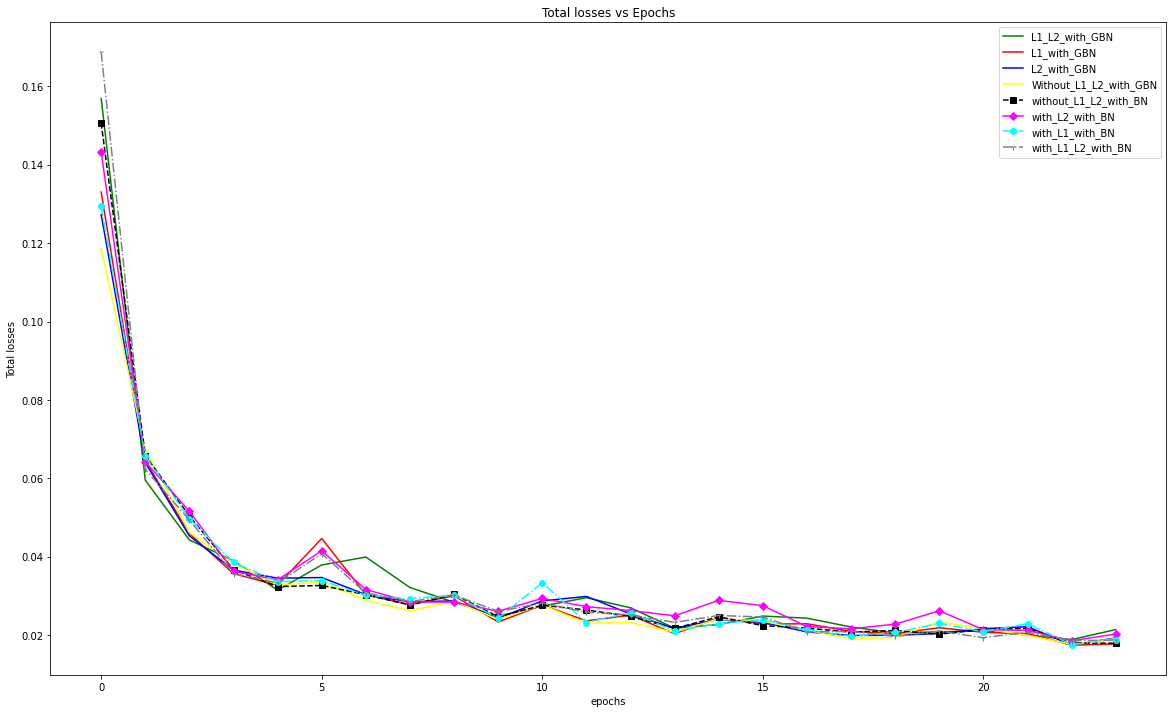

In [0]:
plt.figure(figsize=(20,12))
plt.plot(total_loss[0],color='Green',label='L1_L2_with_GBN')
plt.plot(total_loss[1],color='Red',label='L1_with_GBN')
plt.plot(total_loss[2],color='Blue',label='L2_with_GBN')
plt.plot(total_loss[3],color='Yellow',label='Without_L1_L2_with_GBN')
plt.plot(total_loss[4],c='Black',marker = 's' , ls = '--' , label = 'without_L1_L2_with_BN' )
plt.plot(total_loss[6],c='Magenta', marker = 'D' , ls = '-' , label = 'with_L2_with_BN' )
plt.plot(total_loss[5],c='Cyan' , marker = 'o' , ls = '-.' , label = 'with_L1_with_BN')
plt.plot(total_loss[7],c='Grey' , marker = '1' , ls = '-.' , label = 'with_L1_L2_with_BN')
plt.xlabel('Total Epoch ')
plt.ylabel(' Loss ')
plt.legend(loc = 'upper left' , bbox_to_anchor = (1,1))

plt.title('Total losses vs Epochs')
plt.legend()
plt.ylabel('Total losses')
plt.xlabel('epochs')
plt.show()

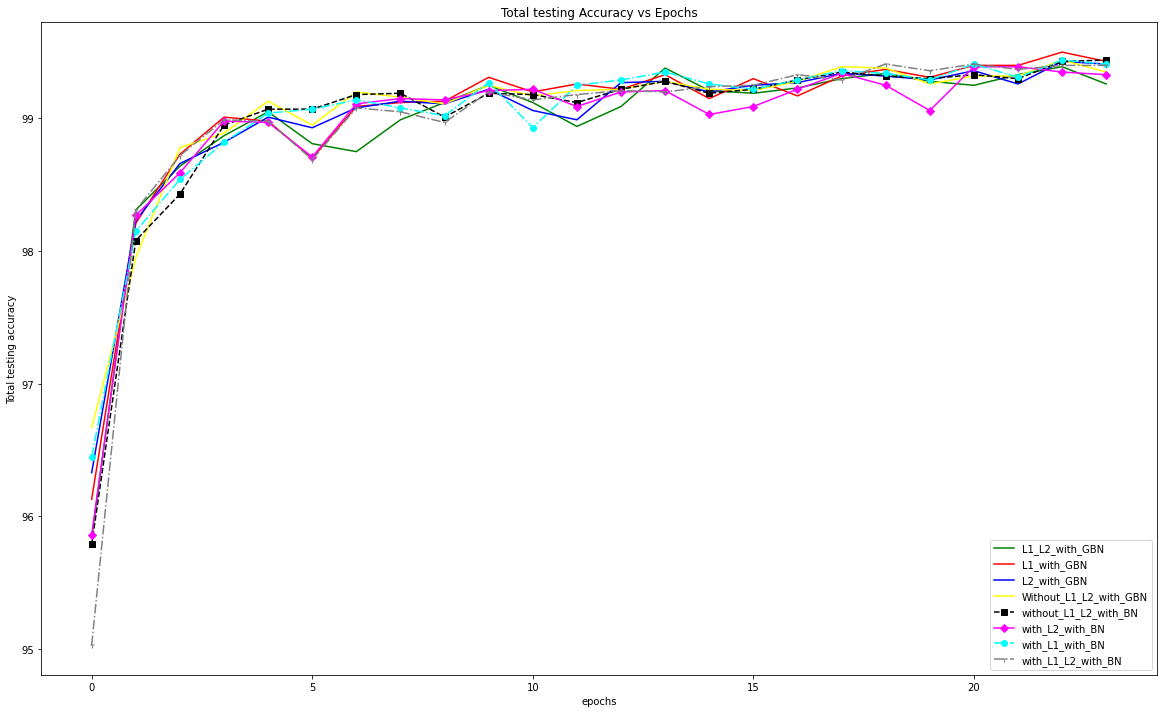

In [0]:
plt.figure(figsize=(20,12))
plt.plot(total_acc[0],color='Green',label='L1_L2_with_GBN')
plt.plot(total_acc[1],color='Red',label='L1_with_GBN')
plt.plot(total_acc[2],color='Blue',label='L2_with_GBN')
plt.plot(total_acc[3],color='Yellow',label='Without_L1_L2_with_GBN')
plt.plot(total_acc[4],c='Black',marker = 's' , ls = '--' , label = 'without_L1_L2_with_BN' )
plt.plot(total_acc[6],c='Magenta', marker = 'D' , ls = '-' , label = 'with_L2_with_BN' )
plt.plot(total_acc[5],c='Cyan' , marker = 'o' , ls = '-.' , label = 'with_L1_with_BN')
plt.plot(total_acc[7],c='Grey' , marker = '1' , ls = '-.' , label = 'with_L1_L2_with_BN')
plt.xlabel('Total Epoch ')
plt.ylabel(' Accuracy ')
plt.legend(loc = 'upper left' , bbox_to_anchor = (1,1))

plt.title('Total testing Accuracy vs Epochs')
plt.legend()
plt.ylabel('Total testing accuracy')
plt.xlabel('epochs')
plt.show()